# Basin Modeling Framework
## 01 Half Graben example
 
version 0.3

07/07/2017 Use pressure calibration solver callback function

Romain Beucher (romain.beucher@unimelb.edu.au)

The following is an example of a lithospheric scale model.

In [1]:
from __future__ import print_function
import underworld as uw
import underworld.function as fn
import numpy as np

# LMR utilities
from unsupported.geodynamics import *
import unsupported.scaling as sca
from unsupported.scaling import nonDimensionalize as nd
from unsupported.lithopress import lithoPressure
from unsupported.LecodeIsostasy import lecode_tools_isostasy
import unsupported.rheology as rheology

# Output
import h5py
import os

# Visualisation
import glucifer
from underworld.utils import is_kernel
import matplotlib.pyplot as plt

print(uw.__version__)

/home/julian/codes/clean_uw/unsupported/scaling/__init__.py:13: UserWarning: 

    The scaling module is not supported.

    It requires 'pint' as a dependency.

    You can install pint by running:

    'pip install pint' in a terminal

    Questions should be addressed to romain.beucher@unimelb.edu.au 
 
  Questions should be addressed to romain.beucher@unimelb.edu.au \n """
/home/julian/codes/clean_uw/unsupported/lithopress/__init__.py:8: UserWarning: 

The lithopress module is not supported.

Questions should be addressed to romain.beucher@unimelb.edu.au 
 
  Questions should be addressed to romain.beucher@unimelb.edu.au \n """
/home/julian/codes/clean_uw/unsupported/LecodeIsostasy/__init__.py:10: UserWarning: 

    The LecodeIsostasy module is not supported.

    Questions should be addressed to romain.beucher@unimelb.edu.au 
 
  Questions should be addressed to romain.beucher@unimelb.edu.au \n """


2.4.0-dev
/home/julian/codes/clean_uw/underworld/__init__.pyc


In [2]:
outputDir = './output/'
        
if uw.rank() == 0:
    if not os.path.exists(outputDir):
        os.makedirs(outputDir)

## Options

In [3]:
Erosion = False
Sedimentation = True
BottomStressBC = False
BottomLecodeIsostasyBC = True

# Scaling

We define a set of physical values that are chosen to represent some characterics of the system we are aiming to model. Those values are then used to calculate a set of scaling coefficients that we will used to scale the different dimensions of our problem. That step is not mandatory but reduce the potential for numerical errors and is generally considered good practice. The *scaling* python dictionary can be seen as a bridge between real world and model world dimensions.

All the parameters are defined with natural units using the pint python module. There is no obligation to use SI units but that is of course encouraged...As pint knows about prefixes, you can freely use them without worrying about conversion.

In [4]:
u = sca.UnitRegistry

# Characteristic values of the system
half_rate = 1.8 * u.centimeter / u.year
model_length = 360e3 * u.meter
model_height = 120e3 * u.meter
refViscosity = 1e24 * u.pascal * u.second
surfaceTemp = 273.15 * u.degK
baseModelTemp = 1603.15 * u.degK
bodyforce = 3300 * u.kilogram / u.metre**3 * 9.81 * u.meter / u.second**2

KL = model_length
Kt = KL / half_rate
KM = bodyforce * KL**2 * Kt**2
KT = (baseModelTemp - surfaceTemp)

sca.scaling["[length]"] = KL
sca.scaling["[time]"] = Kt
sca.scaling["[mass]"]= KM
sca.scaling["[temperature]"] = KT

# General parameters

We first define some general parameters and scale them by using the *nonDimensionalize* function available from the *scaling* module. Note that we aliased the function to *nd* in order to facilitate reading but those are equivalent. We will only use *nd* in the following.

In [5]:
gravity = nd(9.81 * u.meter / u.second**2)
R = nd(8.3144621 * u.joule / u.mole / u.degK)

# Geometry of the model

We define the dimensions and extent of the model on a regular cartesian mesh.

In [6]:
nx = 180
ny = 60

minX = nd(   0. * u.kilometer)
maxX = nd( 360. * u.kilometer)
minY = nd(-110. * u.kilometer)
maxY = nd(  10. * u.kilometer)

mesh = uw.mesh.FeMesh_Cartesian(elementType = ("Q1/dQ0"),
                                elementRes  = (nx, ny),
                                minCoord    = (minX, minY),
                                maxCoord    = (maxX, maxY),
                                periodic    = (False, False))

In our problem, the material history is attached to the particles while the velocity field and the state variables such as the pressure and the temperature are attached to the mesh.
We first need to define a swarm of particles and a set of mesh and swarm variables.

### Particle Swarm

In [7]:
swarm  = uw.swarm.Swarm( mesh = mesh, particleEscape=True)
swarmLayout = uw.swarm.layouts.GlobalSpaceFillerLayout( swarm = swarm, particlesPerCell=25 )
swarm.populate_using_layout( layout = swarmLayout )

### Mesh Variables

In [8]:
velocityField = uw.mesh.MeshVariable( mesh=mesh, nodeDofCount=mesh.dim )
pressureField = uw.mesh.MeshVariable( mesh=mesh.subMesh, nodeDofCount=1 )
solverPressure   = uw.mesh.MeshVariable( mesh=mesh.subMesh, nodeDofCount=1 )
temperatureField    = uw.mesh.MeshVariable( mesh=mesh, nodeDofCount=1 )
temperatureDotField = uw.mesh.MeshVariable( mesh=mesh ,nodeDofCount=1)
tractionField = uw.mesh.MeshVariable( mesh=mesh ,nodeDofCount=2)

# It is considered good practice to initialise the data arrays to 0.
velocityField.data[...]  = 0.0
pressureField.data[...]  = 0.0
solverPressure.data[...]  = 0.0
temperatureField.data[...] = 0.0
temperatureDotField.data[...] = 0.0
tractionField.data[...] = 0.0

### Swarm Variables

In [9]:
materialIndexField = swarm.add_variable( dataType="int", count=1 )
viscosityField  = swarm.add_variable( dataType="double", count=1)
cumulativeTotalStrain = swarm.add_variable( dataType="double", count=1)
viscosityVar = swarm.add_variable(dataType="double", count=1)

cumulativeTotalStrain.data[...] = 0.0

# Visualisation

Underworld2 offers many options for visualisation. In the context of this Jupyer notebook we will use glucifer functions to visualise the progression of our setup and the results of the model.

In [10]:
# Pressure Field 
if is_kernel():
    figPressure = glucifer.Figure( figsize=(1200,400))
    figPressure.append(glucifer.objects.Surface(mesh, pressureField))

# Temperature Field
if is_kernel():
    figTemp = glucifer.Figure(figsize=(1200,400))
    figTemp.append(glucifer.objects.Surface(mesh, temperatureField))

# Velocity Field
if is_kernel():
    FigVelocity = glucifer.Figure(figsize=(1200,400))
    FigVelocity.append(glucifer.objects.Points(swarm, materialIndexField, pointSize=3.0))
    FigVelocity.append(glucifer.objects.VectorArrows(mesh, velocityField, scaling=0.03, arrowHead=10., resolutionI=25, resolutionJ=10)) 

# Material Swarm
if is_kernel():
    FigMaterials = glucifer.Figure( figsize=(1200,400))
    FigMaterials.append(glucifer.objects.Points(swarm, fn_colour=materialIndexField, fn_size=2.0))

Parameter 'resolutionI' is deprecated, please use resolution=[I,J,K]
Parameter 'resolutionJ' is deprecated, please use resolution=[I,J,K]


# Initial Setup

## Material distribution

The way we choose do define the initial set up is based on the distribution of the different materials (or phases).

In [11]:
air = Material()
uppercrust = Material()
midcrust = Material()
lowercrust = Material()
heavycrust = Material()
mantle = Material()
fault = Material()
sediment = Material()

materials = [fault, air, uppercrust, midcrust, heavycrust, lowercrust, mantle, sediment]

The initial set up is just a layered cake. We define the top and bottom of each layer and use the utils.layer function to define the shape of the material.

In [12]:
air.top           = maxY
air.bottom        = nd(  0.  * u.kilometer)
uppercrust.top    = nd(  0.  * u.kilometer)
uppercrust.bottom = nd( -20. * u.kilometer)
midcrust.top      = nd( -20. * u.kilometer)
midcrust.bottom   = nd( -25. * u.kilometer)
lowercrust.top    = nd( -25. * u.kilometer)
lowercrust.bottom = nd( -60. * u.kilometer)
heavycrust.top    = nd( -35. * u.kilometer)
heavycrust.bottom = nd( -40. * u.kilometer)
mantle.top        = nd( -60. * u.kilometer)
mantle.bottom     = nd(-110. * u.kilometer)

for material in materials:
    material.shape = utils.layer(material.top, material.bottom, minX, maxX)

The fault is defined as a polygon:

In [13]:
vertices = [(169  * u.kilometer,  0. * u.kilometer),
            (171. * u.kilometer,  0. * u.kilometer),
            (191. * u.kilometer, -20. * u.kilometer),
            (189. * u.kilometer, -20. * u.kilometer)]

vertices = np.array([(nd(x), nd(y)) for x,y in vertices])
fault.shape = uw.function.shape.Polygon(vertices)

All the shapes being defined, we can now assign a material index to each particle in the material swarm:

In [14]:
conditions = [(obj.shape, obj.index) for obj in materials if obj.shape is not None] 
materialIndexField.data[:] = fn.branching.conditional( conditions ).evaluate(swarm)

It is a good idea to check the setup before proceeding any further:


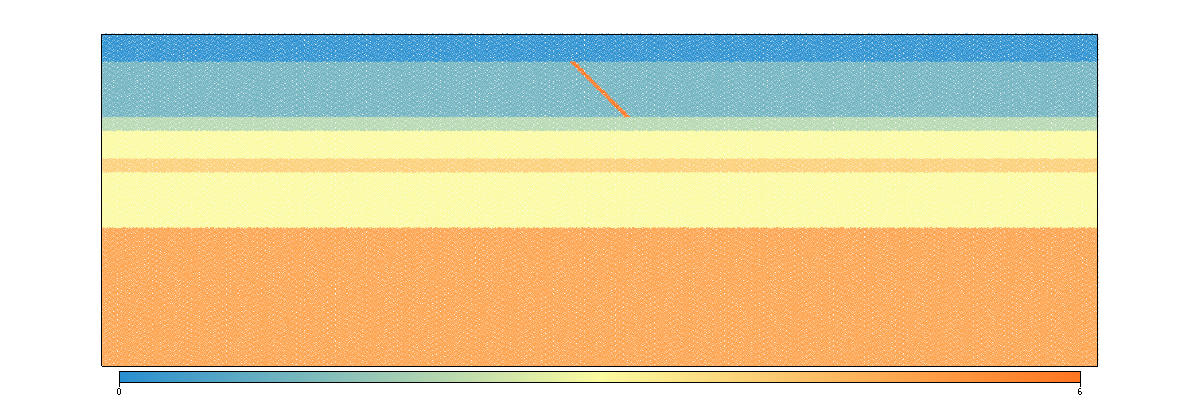

In [15]:
if is_kernel():
    FigMaterials.show()

## Material properties

The swarm is initialialised but we now need to define the physical properties of our materials:

### Densities

In [16]:
# Densities
air.density         = nd(   1. * u.kilogram / u.metre**3)
sediment.density    = nd(2500. * u.kilogram / u.metre**3)
uppercrust.density  = nd(2620. * u.kilogram / u.metre**3)
midcrust.density    = nd(2900. * u.kilogram / u.metre**3)
lowercrust.density  = nd(2800. * u.kilogram / u.metre**3)
heavycrust.density  = nd(2900. * u.kilogram / u.metre**3)
mantle.density      = nd(3370. * u.kilogram / u.metre**3)
fault.density       = nd(2620. * u.kilogram / u.metre**3)

### Thermal Diffusivities

In [17]:
global_diffusivity = nd(1e-6 * u.metre**2 / u.second) 
for material in materials:
    material.diffusivity = global_diffusivity

### Thermal Capacities

In [18]:
global_cp = nd(1000. * u.joule / (u.kelvin * u.kilogram))
for material in materials:
    material.capacity = global_cp
air.capacity = nd(100. * u.joule / (u.kelvin * u.kilogram))

### Thermal Expansivities

In [19]:
global_expansivity = nd(3e-5 / u.kelvin)
for material in materials:
    material.thermalExpansivity = global_expansivity
air.thermalExpansivity = 0.0

### Radiogenic Heat Production

In [20]:
air.radiogenicHeatProd        = 0.0
sediment.radiogenicHeatProd   = nd(    0.7 * u.microwatt / u.meter**3)
uppercrust.radiogenicHeatProd = nd(    0.7 * u.microwatt / u.meter**3)
midcrust.radiogenicHeatProd   = nd(    0.6 * u.microwatt / u.meter**3)
lowercrust.radiogenicHeatProd = nd(    0.4 * u.microwatt / u.meter**3)
heavycrust.radiogenicHeatProd = nd(    0.6 * u.microwatt / u.meter**3)
mantle.radiogenicHeatProd     = nd(0.02e-6 * u.microwatt / u.meter**3)
fault.radiogenicHeatProd      = nd(    0.7 * u.microwatt / u.meter**3)

### Buoyancy Force

Define how the material densities interact with the gravity field.

In [21]:
Tref = nd(273.15 *u.degK)

densityMap = {}
for material in materials:
    densityMap[material.index] = material.density * (1.0 - material.thermalExpansivity * (temperatureField - Tref))
    
densityFn = fn.branching.map( fn_key=materialIndexField, mapping=densityMap )

z_hat = ( 0.0, -1.0 )
buoyancyFn = densityFn * z_hat * gravity

## Material Rheologies

In [22]:
air.rheology        = Rheology()
sediment.rheology   = Rheology()
uppercrust.rheology = Rheology()
midcrust.rheology   = Rheology()
lowercrust.rheology = Rheology()
heavycrust.rheology = Rheology()
mantle.rheology     = Rheology()
fault.rheology      = Rheology()

### Strain Rate and Temperature Dependent Viscosity function


In [23]:
# symmetric component of the gradient of the flow velocity.
strainRateFn = fn.tensor.symmetric( velocityField.fn_gradient )
strainRate_2ndInvariantFn = fn.tensor.second_invariant(strainRateFn) 

In [24]:
def powerLaw(A, Q, n, Va, R, strainRateFn, pressureFn, temperatureFn, DefaultSRInvariant, f=1.0):
    I = fn.misc.max(fn.tensor.second_invariant(strainRateFn), DefaultSRInvariant)
    P = pressureFn
    T = temperatureFn       
        
    return (f * A**(-1.0 / n) * I**((1.0-n)/n) * 
            fn.math.exp((Q + P * Va)/(R*T*n)))

In [25]:
SRT_WetQ_Patterson1990 = rheology.SRT.SRT_WetQ_Patterson1990
SRT_WetQ_Goetze1978    = rheology.SRT.SRT_WetQ_Goetze1978
SRT_DryMG_Wang2012     = rheology.SRT.SRT_DryMG_Wang2012
SRT_WOl_Hirth2003      = rheology.SRT.SRT_WOl_Hirth2003

# Scale the flaw law parameters
SRT_WetQ_Patterson1990 = {k: nd(v) for k, v in SRT_WetQ_Patterson1990.items()}
SRT_WetQ_Goetze1978    = {k: nd(v) for k, v in SRT_WetQ_Goetze1978.items()}
SRT_DryMG_Wang2012     = {k: nd(v) for k, v in SRT_DryMG_Wang2012.items()}
SRT_WOl_Hirth2003      = {k: nd(v) for k, v in SRT_WOl_Hirth2003.items()}

In [26]:
  # Define Effective viscosity functions
SRT_WetQ_Patterson1990Fn = powerLaw(R=R,strainRateFn=strainRateFn, pressureFn=pressureField,
                                    temperatureFn=temperatureField, **SRT_WetQ_Patterson1990)
SRT_WetQ_Goetze1978Fn = powerLaw(R=R, strainRateFn=strainRateFn, pressureFn=pressureField,
                                 temperatureFn=temperatureField, **SRT_WetQ_Goetze1978)
SRT_DryMG_Wang2012Fn = powerLaw(R=R, strainRateFn=strainRateFn, pressureFn=pressureField, 
                                temperatureFn=temperatureField, **SRT_DryMG_Wang2012)
SRT_WOl_Hirth2003Fn = powerLaw(R=R, strainRateFn=strainRateFn, pressureFn=pressureField, 
                               temperatureFn=temperatureField, **SRT_WOl_Hirth2003)

In [27]:
# Assign function to materials
air.rheology.viscosity        = fn.misc.constant(nd(1e19 * u.pascal * u.second))
sediment.rheology.viscosity   = SRT_WetQ_Patterson1990Fn
uppercrust.rheology.viscosity = SRT_WetQ_Patterson1990Fn
midcrust.rheology.viscosity   = SRT_WetQ_Goetze1978Fn
lowercrust.rheology.viscosity = SRT_DryMG_Wang2012Fn
heavycrust.rheology.viscosity = SRT_WetQ_Goetze1978Fn
mantle.rheology.viscosity     = fn.misc.constant(nd(1e23 * u.pascal * u.second))
fault.rheology.viscosity      = fn.misc.constant(nd(1e19 * u.pascal * u.second))

## Plasticity

In [28]:
def cohesionWeakening(cumulativeTotalStrain, Cohesion, CohesionSw, epsilon1=0.5, epsilon2=1.5, **kwargs):

    cohesionVal = [(cumulativeTotalStrain < epsilon1, fn.misc.constant(Cohesion)),
                   (cumulativeTotalStrain > epsilon2, fn.misc.constant(CohesionSw)),
                   (True, Cohesion + ((Cohesion - CohesionSw)/(epsilon1 - epsilon2)) * (cumulativeTotalStrain - epsilon1))]

    return fn.branching.conditional(cohesionVal)

def frictionWeakening(cumulativeTotalStrain, FrictionCoef, FrictionCoefSw, epsilon1=0.5, epsilon2=1.5, **kwargs):

    frictionVal = [(cumulativeTotalStrain < epsilon1, fn.misc.constant(FrictionCoef)),
                   (cumulativeTotalStrain > epsilon2, fn.misc.constant(FrictionCoefSw)),
                   (True, FrictionCoef + ((FrictionCoef - FrictionCoefSw)/(epsilon1 - epsilon2)) * (cumulativeTotalStrain - epsilon1))]

    frictionVal = fn.branching.conditional(frictionVal)
    
    return fn.math.atan(frictionVal)

In [29]:
Yield_UpperCrust_Rey2010 = rheology.Yield.Yield_UpperCrust_Rey2010
Yield_lowerCrust_Rey2010 = rheology.Yield.Yield_lowerCrust_Rey2010
Yield_mantle_Rey2010 = rheology.Yield.Yield_mantle_Rey2010

Yield_UpperCrust_Rey2010 = {k: nd(v) for k, v in Yield_UpperCrust_Rey2010.items()}
Yield_lowerCrust_Rey2010 = {k: nd(v) for k, v in Yield_lowerCrust_Rey2010.items()}
Yield_mantle_Rey2010     = {k: nd(v) for k, v in Yield_mantle_Rey2010.items()}

In [30]:
sediment.rheology.cohesion   = cohesionWeakening(cumulativeTotalStrain, **Yield_UpperCrust_Rey2010)
uppercrust.rheology.cohesion = cohesionWeakening(cumulativeTotalStrain, **Yield_UpperCrust_Rey2010)
midcrust.rheology.cohesion   = cohesionWeakening(cumulativeTotalStrain, **Yield_lowerCrust_Rey2010)
lowercrust.rheology.cohesion = cohesionWeakening(cumulativeTotalStrain, **Yield_lowerCrust_Rey2010)
heavycrust.rheology.cohesion = cohesionWeakening(cumulativeTotalStrain, **Yield_lowerCrust_Rey2010)
fault.rheology.cohesion      = cohesionWeakening(cumulativeTotalStrain, **Yield_mantle_Rey2010)

In [31]:
sediment.rheology.friction   = frictionWeakening(cumulativeTotalStrain, **Yield_UpperCrust_Rey2010)
uppercrust.rheology.friction = frictionWeakening(cumulativeTotalStrain, **Yield_UpperCrust_Rey2010)
midcrust.rheology.friction   = frictionWeakening(cumulativeTotalStrain, **Yield_lowerCrust_Rey2010)
lowercrust.rheology.friction = frictionWeakening(cumulativeTotalStrain, **Yield_lowerCrust_Rey2010)
heavycrust.rheology.friction = frictionWeakening(cumulativeTotalStrain, **Yield_lowerCrust_Rey2010)
fault.rheology.friction      = frictionWeakening(cumulativeTotalStrain, **Yield_mantle_Rey2010)

In [32]:
#Plane Strain Drucker-Prager
DefaultSRInvariant = nd(1.0e-15 / u.second)

for material in materials:
    rheology = material.rheology
    if rheology.cohesion != None and rheology.friction != None:
        C = rheology.cohesion
        Phi = rheology.friction
        YieldStress = C*fn.math.cos(Phi) + pressureField * fn.math.sin(Phi)
        rheology.plasticity =  0.5 * YieldStress / fn.misc.max(strainRate_2ndInvariantFn, DefaultSRInvariant) 
    else:
        rheology.plasticity = rheology.viscosity

### Viscosity Limiter

In [33]:
# Viscosity limiter
min_viscosity = air.rheology.viscosity
max_viscosity = nd(1e25 * u.pascal * u.second)

ViscosityMap = {}
for material in materials:
    plasticity = material.rheology.plasticity
    viscosity = material.rheology.viscosity
    ViscosityMap[material.index] = fn.exception.SafeMaths( fn.misc.min(
                                         fn.misc.max(
                                            fn.misc.min(plasticity, viscosity), 
                                            min_viscosity),
                                      max_viscosity))

viscosityFn = fn.branching.map(fn_key = materialIndexField, mapping = ViscosityMap)

BGViscosityMap = {}
for material in materials:
    BGViscosityMap[material.index] = fn.misc.max(fn.misc.min(material.rheology.viscosity, max_viscosity), min_viscosity)

backgroundViscosityFn = fn.branching.map(fn_key = materialIndexField, mapping = BGViscosityMap)

### Yielding criterion

In [34]:
SYconditions = [(viscosityFn < backgroundViscosityFn, strainRate_2ndInvariantFn),
                (True, 0.0)]

isYielding = fn.branching.conditional(SYconditions)

## Initial Temperature

Calculate Steady state thermal field as initial condition

In [35]:
surfaceTemp = nd(293.15 * u.degK)
airTemp     = nd(293.15 * u.degK)
mantleTemp  = nd(1603.15 * u.degK)

In [36]:
DiffusivityMap = {}
for material in materials:
    DiffusivityMap[material.index] = material.diffusivity

DiffusivityFn = fn.branching.map(fn_key = materialIndexField, mapping = DiffusivityMap)

In [37]:
HeatProdMap = {}
for material in materials:
    HeatProdMap[material.index] = material.radiogenicHeatProd / (material.density * material.capacity)

HeatProdFn = fn.branching.map(fn_key = materialIndexField, mapping = HeatProdMap)

In [38]:
coords = fn.input()
airnodes = []
mantlenodes = []

for index, coords in enumerate(mesh.data):
    if coords[1] < mantle.top:
        temperatureField.data[index] = mantleTemp
        mantlenodes.append(index)
    elif coords[1] > uppercrust.top:
        temperatureField.data[index] = surfaceTemp
        airnodes.append(index)
        
airIndices = uw.mesh.FeMesh_IndexSet(mesh, topologicalIndex=0, size=mesh.nodesGlobal, fromObject=airnodes)
mantleIndices = uw.mesh.FeMesh_IndexSet(mesh, topologicalIndex=0, size=mesh.nodesGlobal, fromObject=mantlenodes)

In [39]:
temperatureBCs0 = uw.conditions.DirichletCondition( variable = temperatureField, 
                                                    indexSetsPerDof = (mantleIndices+airIndices,))

heatequation = uw.systems.SteadyStateHeat(temperatureField=temperatureField,
                                          fn_diffusivity=DiffusivityFn,
                                          fn_heating = HeatProdFn,
                                          conditions=[temperatureBCs0,])
heatsolver = uw.systems.Solver(heatequation)
heatsolver.solve(nonLinearIterate=True)


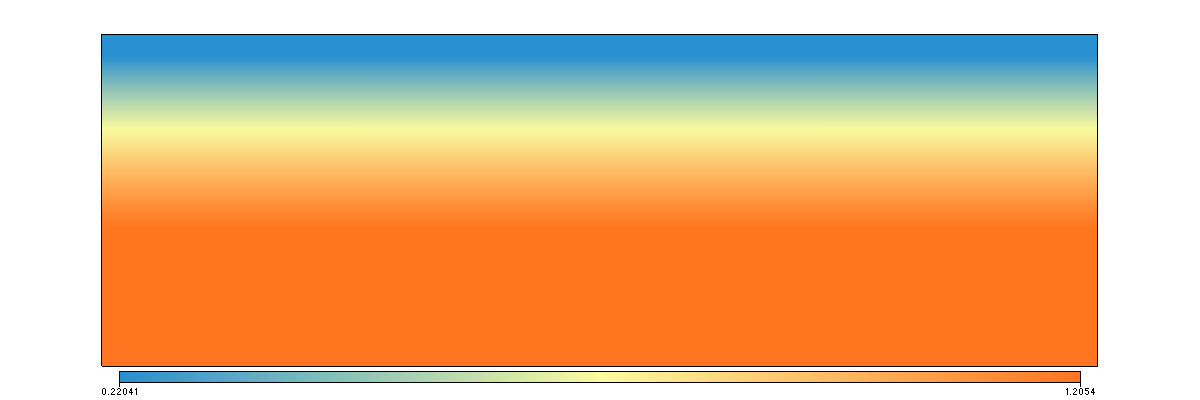

In [40]:
if is_kernel():
    figTemp.show()

## Initial Pressure

Calculate lithostatic pressure field as initial condition.

In [41]:
def smooth_pressure(mesh, pressure):
    # Smooths the pressure field.
    # Assuming that pressure lies on the submesh, do a cell -> nodes -> cell
    # projection.
    NodePressure = uw.mesh.MeshVariable(mesh, nodeDofCount=1)
    Cell2Nodes = uw.utils.MeshVariable_Projection(NodePressure, pressure, type=0)
    #Nodes2Cell = uw.utils.MeshVariable_Projection(pressure, NodePressure, type=0)
    Cell2Nodes.solve()
    #Nodes2Cell.solve()

In [42]:
pressureField.data[:], LPresBot = lithoPressure(mesh,densityFn, gravity)
smooth_pressure(mesh, pressureField)


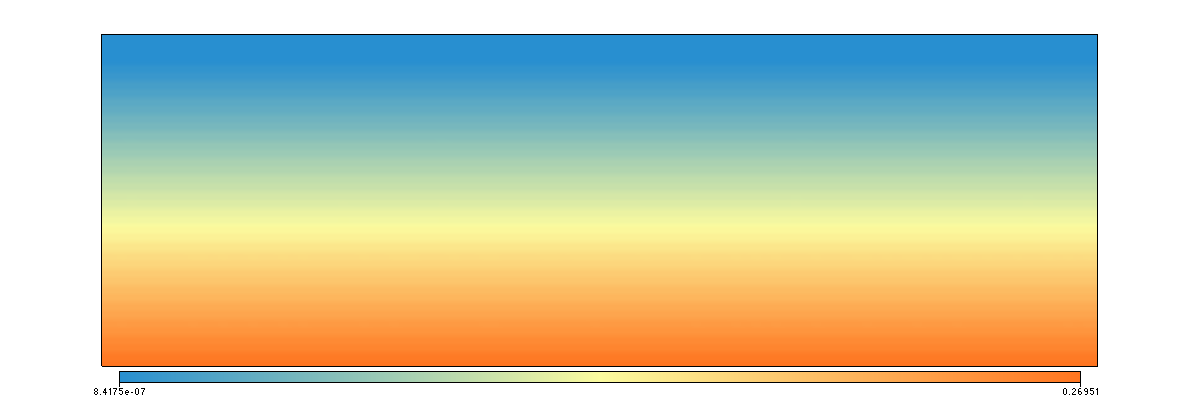

In [43]:
if is_kernel(): 
    figPressure.show()

## Initial Stress Field

In [44]:
if BottomStressBC:
    val = LPresBot[4]

    for node in mesh.specialSets["MinJ_VertexSet"]:
        tractionField.data[node] = [0.0, 1.0*val]

# Boundary conditions

In [45]:
iWalls = mesh.specialSets["MinI_VertexSet"] + mesh.specialSets["MaxI_VertexSet"]
jWalls = mesh.specialSets["MinJ_VertexSet"] + mesh.specialSets["MaxJ_VertexSet"]
base   = mesh.specialSets["MinJ_VertexSet"]
top    = mesh.specialSets["MaxJ_VertexSet"]

topCorners = mesh.specialSets["MaxJ_VertexSet"]
topCorners.AND(iWalls)

botCorners = mesh.specialSets["MinJ_VertexSet"]
botCorners.AND(iWalls)

## Kinematic Boundary Conditions

In [46]:
# Define some time dependent velocities at the Walls
left_Wall_VC = [(fn.input() < nd(3.2 * u.megayear), nd(-1.8 * u.centimeter / u.year)),
                (True, 0.0)]
left_velocity = fn.branching.conditional(left_Wall_VC)

right_Wall_VC = [(fn.input() < nd(3.2 * u.megayear), nd(1.8 * u.centimeter / u.year)),
                (True, 0.0)]
right_velocity = fn.branching.conditional(right_Wall_VC)

In [47]:
for index in mesh.specialSets["MinI_VertexSet"]:
    velocityField.data[index] = [left_velocity.evaluate(0.0),0.0]
for index in mesh.specialSets["MaxI_VertexSet"]:
    velocityField.data[index] = [right_velocity.evaluate(0.0),0.0]    

In [48]:
if BottomStressBC:
    stokesBC = uw.conditions.DirichletCondition(variable=velocityField, 
                                                indexSetsPerDof=(iWalls, topCorners+botCorners))

    stressBc = uw.conditions.NeumannCondition(fn_flux=tractionField, variable=velocityField, 
                                              indexSetsPerDof=(None,base-botCorners))
    
else:
    stokesBC = uw.conditions.DirichletCondition( variable      = velocityField, 
                                                 indexSetsPerDof = (iWalls, base))

    stressBc = None

## Thermal Boundary Conditions

In [49]:
DirichletTBCs = uw.conditions.DirichletCondition( variable = temperatureField, indexSetsPerDof = [airIndices,])
FluxTBCs = uw.conditions.NeumannCondition( fn_flux=[0.0], variable = temperatureField, indexSetsPerDof = base )

advdiffSystem = uw.systems.AdvectionDiffusion(temperatureField,
                                              temperatureDotField,
                                              velocityField=velocityField,
                                              fn_diffusivity=DiffusivityFn,
                                              fn_sourceTerm=HeatProdFn,
                                              conditions=[DirichletTBCs, FluxTBCs])

## Stokes

In [50]:
if BottomStressBC:
    conditions = [stokesBC, stressBc]
else:
    conditions = [stokesBC,]


stokes = uw.systems.Stokes(    velocityField = velocityField, 
                               pressureField = solverPressure,
                               conditions    = conditions,
                               fn_viscosity  = viscosityFn, 
                               fn_bodyforce  = buoyancyFn)

solver = uw.systems.Solver( stokes )
solver.set_inner_method("mumps")
solver.set_penalty(1e6) 

# Melt 

In [51]:
# meltField = uw.mesh.MeshVariable(mymesh, nodeDofCount=1)
# old_melt = swarm.add_variable( dataType="double", count=1 )

# meltParams = {
#     'lhf'            : 200, # kJ/kg the latent heat of fusion
#     'viscosityChange': 1e3, 
#     'densityChange'  : 0.13 
# }

# def evalMelt( pressure, temperature ):
#     T_s = np.polynomial.polynomial.polyval(pressure, [1063,-1.2e-7,1.2e-16])
#     T_l = np.polynomial.polynomial.polyval(pressure, [1563.0,-1.2e-7,1.2e-16])
#     T_ss = ( temperature - 0.5*(T_s+T_l) ) / (T_l-T_s)
#     return np.where( (-0.5<T_ss) & (T_ss<0.5), 
#                      0.5 + T_ss + ( T_ss*T_ss -0.25 )*( 0.4256 + 2.988 * T_ss ), 
#                      0.0  )

# Surface Processes

## Simple Erosion

In [52]:
sealevel = nd(0.0 * u.kilometer)

AboveWaterCond = [(((materialIndexField > air.index + 0.1 ) & (fn.input()[1] > sealevel)), air.index), (True, materialIndexField)]
erosionFn = fn.branching.conditional(AboveWaterCond)

## Simple Sedimentation

In [53]:
UnderWaterCond = [(((materialIndexField < air.index + 0.1 ) & (fn.input()[1] < sealevel)), sediment.index), (True, materialIndexField)]
sedimentationFn = fn.branching.conditional(UnderWaterCond)

# Plastic strain accumulation Envelope

In [54]:
import math
# envelope to ensure the localisation stays clear of the boundary
def boundary(xx, minX, maxX, width, power):
    zz = xx / (maxX - minX)
    return (np.tanh(zz*width) + np.tanh((1.0-zz)*width) - math.tanh(width))**power


In [55]:
if uw.nProcs() == 1:   # Serial
    xx = np.arange(minX, maxX, (maxX-minX)/nx)
    yy = boundary(xx, minX, maxX, 20, 4)
    plt.scatter(xx,yy)

# Passive Tracers

In [56]:
surfaceSwarm = uw.swarm.Swarm( mesh=mesh , particleEscape=True)

surfacePoints = np.zeros((1000,2))
surfacePoints[:,0] = np.linspace(minX-.01, maxX+0.01, 1000)
surfacePoints[:,1] = uppercrust.top 
    
surfaceSwarm.add_particles_with_coordinates( surfacePoints )

Emin_max = fn.view.min_max(surfaceSwarm.particleCoordinates[1])

pass

# Pressure Calibration

In [57]:
surfaceArea = uw.utils.Integral(fn=1.0,mesh=mesh, integrationType='surface', surfaceIndexSet=top)
surfacePressureIntegral = uw.utils.Integral(fn=solverPressure, mesh=mesh, integrationType='surface', surfaceIndexSet=top)

# a callback function to calibrate the pressure - will pass to solver later
def pressure_calibrate():
    (area,) = surfaceArea.evaluate()
    (p0,) = surfacePressureIntegral.evaluate()
    offset = p0/area
    pressureField.data[:] -= offset
    smooth_pressure(mesh, pressureField)

## Checkpoint Function

In [58]:
def checkpoint_function(checkpoint_number, time_years):
    
    print('Writing Underworld outputs (years)',time_years)
    
    mH = mesh.save(os.path.join(outputDir, "mesh.h5"), scaling=True, units=u.kilometers)

    file_prefix = os.path.join(outputDir, 'velocity-%s' % checkpoint_number)
    handle = velocityField.save('%s.h5' % file_prefix, scaling=True, units=u.centimeter/u.year)
    velocityField.xdmf('%s.xdmf' % file_prefix, handle, 'velocity', mH, 'mesh', modeltime=time_years)

    file_prefix = os.path.join(outputDir, 'pressure-%s' % checkpoint_number)
    handle = pressureField.save('%s.h5' % file_prefix, scaling=True, units=u.megapascal)
    pressureField.xdmf('%s.xdmf' % file_prefix, handle, 'pressure', mH, 'mesh', modeltime=time_years)
    
    file_prefix = os.path.join(outputDir, 'temperature-%s' % checkpoint_number)
    handle = temperatureField.save('%s.h5' % file_prefix, scaling=True, units=u.degC)
    temperatureField.xdmf('%s.xdmf' % file_prefix, handle, 'temperature', mH, 'mesh', modeltime=time_years)

    sH = swarm.save(os.path.join(outputDir, 'swarm-%s.h5' % checkpoint_number), units=u.kilometers)

    file_prefix = os.path.join(outputDir, 'material-%s' % checkpoint_number)
    handle = materialIndexField.save('%s.h5' % file_prefix)
    materialIndexField.xdmf('%s.xdmf' % file_prefix, handle, 'material', sH, 'swarm', modeltime=time_years)
    
    tsH = surfaceSwarm.save(os.path.join(outputDir, 'tracer_swarm-%s.h5' % checkpoint_number), units=u.kilometers)

    file_prefix = os.path.join(outputDir, 'tracer-%s' % checkpoint_number)
    handle = surfaceSwarm.particleCoordinates.save('%s.h5' % file_prefix, scaling=True, units=u.kilometers)
    surfaceSwarm.particleCoordinates.xdmf('%s.xdmf' % file_prefix, handle, 'tvar', tsH, 'tracer', modeltime=time_years)

# Main simulation loop
----------------------------------------

In [59]:
advector   = uw.systems.SwarmAdvector( swarm = swarm, velocityField=velocityField, order=2 )
advectorSurface  = uw.systems.SwarmAdvector( swarm = surfaceSwarm, velocityField=velocityField, order=2 )

population_control = uw.swarm.PopulationControl(swarm, 
                                                aggressive=True,splitThreshold=0.15, 
                                                maxDeletions=2,maxSplits=10,
                                                particlesPerCell=20)

In [60]:
time = 0.
endTime = nd(5.0 * u.megayear)

step = 0
nsteps = 2
checkpoint_number = 0

def get_dt(CFL=0.2, threshold = 2500):
    dt3 = nd(threshold * u.year)
    dt4 = CFL * advdiffSystem.get_max_dt()
    return min(dt3,dt4)


while step < nsteps:
    
    solver.solve(nonLinearIterate=True, callback_post_solve = pressure_calibrate)
    
    if step % 1 == 0:
        checkpoint_number +=1
        checkpoint_function(checkpoint_number, sca.Dimensionalize(time, u.years).magnitude)

    # obtain a timestep and apply a courant factor
    dt = get_dt()
         
    if uw.rank()==0:   
        print('step = {0:6d}; time = {1:.3e}'.format(step, sca.Dimensionalize(time, u.megayears)))
        
    uw.barrier()
    
    # update plastic strain
    plasticStrainIncrement = dt * isYielding.evaluate(swarm)
    weight = boundary(swarm.particleCoordinates.data[:,0], minX, maxX, 20, 4)
    plasticStrainIncrement[:,0] *= weight
    cumulativeTotalStrain.data[:] += plasticStrainIncrement
    
    # Solve for temperature
    advdiffSystem.integrate(dt)

    # integrate swarms in time
    advector.integrate(dt, update_owners=True)  
    advectorSurface.integrate(dt, update_owners=True)  

    # repopulate swarm.
    population_control.repopulate() 
    
    # Update velocities at the boundaries
    for index in mesh.specialSets["MinI_VertexSet"]:
        velocityField.data[index, 0] = left_velocity.evaluate(time)
    for index in mesh.specialSets["MaxI_VertexSet"]:
        velocityField.data[index, 0] = right_velocity.evaluate(time)
        
    lecode_tools_isostasy(mesh, swarm, velocityField, densityFn, materialIndexField, mantle.index, average=False)
        
    # Do basic surface processes
    if Sedimentation: 
        materialIndexField.data[:] = sedimentationFn.evaluate(swarm)
    
    if Erosion:
        materialIndexField.data[:] = erosionFn.evaluate(swarm)
       
    step +=1
    time +=dt

Writing Underworld outputs (years) 0.0
step =      0; time = 0.000e+00 megayear
Writing Underworld outputs (years) 2500.0
step =      1; time = 2.500e-03 megayear



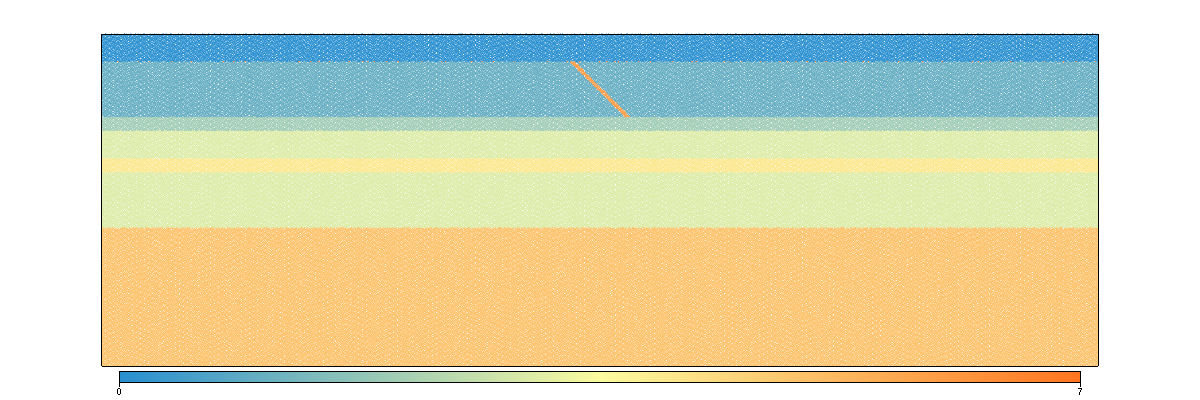

In [61]:
if is_kernel():
    FigMaterials.show()


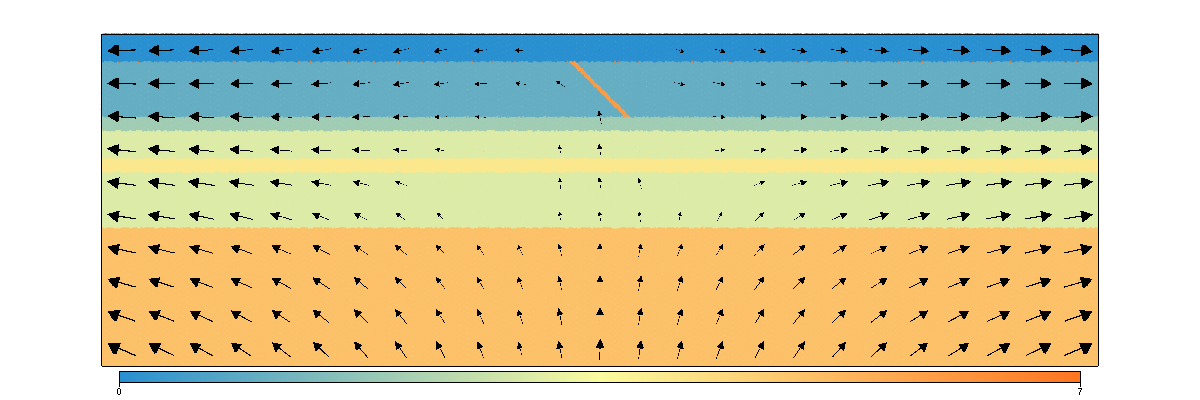

In [62]:
if is_kernel():
    FigVelocity.show()